In [1]:
# =======================
# 📦 IMPORTACIONES
# =======================

# Built-in
import os
import sys
import re
import time
import json
import random
import warnings
from typing import List, Tuple, Dict
import operator

# NumPy, Pandas, Matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    log_loss, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, pairwise_distances
)
from sklearn.exceptions import NotFittedError
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix


# Flower
from flwr.client import ClientApp, NumPyClient
from flwr.common import (
    Context, NDArrays, Metrics, Scalar,
    ndarrays_to_parameters, parameters_to_ndarrays
)
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# LORE
from lore_sa.dataset import TabularDataset
from lore_sa.bbox import sklearn_classifier_bbox
from lore_sa.encoder_decoder import ColumnTransformerEnc
from lore_sa.lore import TabularGeneticGeneratorLore
from lore_sa.surrogate.decision_tree import SuperTree
from lore_sa.rule import Expression, Rule

from lore_sa.client_utils import ClientUtilsMixin  

# Otros
from pathlib import Path
from filelock import FileLock  # pip install filelock
import pandas as pd, os
from graphviz import Digraph
from datetime import datetime

2025-09-10 13:09:16,026	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-09-10 13:09:19,612 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-09-10 13:09:19,612 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-09-10 13:09:19,612 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
2025-09-10 13:09:19,612 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.viewing.view(['quiet'])
2025-09-10 13:09:19,622 graphviz._tools DEBUG    deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'endswith_odd_number_of_backslashes', 'escape_unescaped

In [2]:
# =======================
# ⚙️ VARIABLES GLOBALES
# =======================
UNIQUE_LABELS = []
FEATURES = []
NUM_SERVER_ROUNDS = 2
NUM_CLIENTS = 4
NUM_PARTITIONS_TOTAL = NUM_CLIENTS + 1   # +1 = holdout servidor
SEED = 42
MIN_AVAILABLE_CLIENTS = NUM_CLIENTS
fds = None  # Cache del FederatedDataset
CAT_ENCODINGS = {}
USING_DATASET = None


# Ruta al CSV
csv_path = Path("results/metrics_cliente.csv")

# Crear la carpeta si no existe
csv_path.parent.mkdir(exist_ok=True)

# Si existe el CSV, lo borramos
if csv_path.exists():
    os.remove(csv_path)





# =======================
# 🔧 UTILIDADES MODELO
# =======================

def get_model_parameters(tree_model, nn_model):
    tree_params = [
        int(tree_model.get_params()["max_depth"] or -1),
        int(tree_model.get_params()["min_samples_split"]),
        int(tree_model.get_params()["min_samples_leaf"]),
    ]
    nn_weights = [v.cpu().detach().numpy() for v in nn_model.state_dict().values()]
    return {
        "tree": tree_params,
        "nn": nn_weights,
    }


def set_model_params(tree_model, nn_model, params):
    tree_params = params["tree"]
    nn_weights = params["nn"]

    # Solo si tree_model no es None y tiene set_params
    if tree_model is not None and hasattr(tree_model, "set_params"):
        max_depth = tree_params[0] if tree_params[0] > 0 else None
        tree_model.set_params(
            max_depth=max_depth,
            min_samples_split=tree_params[1],
            min_samples_leaf=tree_params[2],
        )

    # Actualizar pesos de la red neuronal
    state_dict = nn_model.state_dict()
    for (key, _), val in zip(state_dict.items(), nn_weights):
        state_dict[key] = torch.tensor(val)
    nn_model.load_state_dict(state_dict)


# =======================
# 📥 CARGAR DATOS
# =======================

def get_global_onehot_info(flower_dataset_name, class_col):
    partitioner = IidPartitioner(num_partitions=1)
    fds_tmp = FederatedDataset(dataset=flower_dataset_name, partitioners={"train": partitioner})
    df = fds_tmp.load_partition(0, "train").with_format("pandas")[:]

    # Preprocesado estándar
    if "adult_small" in flower_dataset_name.lower():
        drop_cols = ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
        df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    elif "churn" in flower_dataset_name.lower():
        drop_cols = ['customerID', 'TotalCharges']
        df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)
        df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
        df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
        df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'}).astype(str)
        df.dropna(subset=['MonthlyCharges', 'tenure'], inplace=True)
    
    elif "breastcancer" in flower_dataset_name.lower():
        # Preprocesado específico para el dataset de cáncer de mama
        df.drop(columns=['id'], inplace=True, errors='ignore')



    for col in df.select_dtypes(include=["object"]).columns:
        if df[col].nunique() < 50:
            df[col] = df[col].astype("category")

    cat_features = [col for col in df.select_dtypes(include="category").columns if col != class_col]
    num_features = [col for col in df.columns if df[col].dtype.kind in "fi" and col != class_col]

    ohe = OneHotEncoder(handle_unknown="ignore")
    ohe.fit(df[cat_features])
    categories_global = ohe.categories_
    onehot_columns = ohe.get_feature_names_out(cat_features).tolist()
    return cat_features, num_features, categories_global, onehot_columns



def load_data_general(flower_dataset_name: str, class_col: str, partition_id: int, num_partitions: int):
    global fds, UNIQUE_LABELS, FEATURES

    # Saca info global siempre al principio
    cat_features, num_features, categories_global, onehot_columns = get_global_onehot_info(flower_dataset_name, class_col)

    if fds is None:
        partitioner = IidPartitioner(num_partitions=num_partitions)
        fds = FederatedDataset(dataset=flower_dataset_name, partitioners={"train": partitioner})

    dataset = fds.load_partition(partition_id, "train").with_format("pandas")[:]

    # Preprocesado específico por dataset
    if "adult" in flower_dataset_name.lower():
        drop_cols = ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
        dataset.drop(columns=[col for col in drop_cols if col in dataset.columns], inplace=True)

    elif "churn" in flower_dataset_name.lower():
        drop_cols = ['customerID', 'TotalCharges']
        dataset.drop(columns=[col for col in drop_cols if col in dataset.columns], inplace=True)
        dataset['MonthlyCharges'] = pd.to_numeric(dataset['MonthlyCharges'], errors='coerce')
        dataset['tenure'] = pd.to_numeric(dataset['tenure'], errors='coerce')
        dataset['SeniorCitizen'] = dataset['SeniorCitizen'].map({0: 'No', 1: 'Yes'}).astype(str)

        dataset.dropna(subset=['MonthlyCharges', 'tenure'], inplace=True)

    elif "breastcancer" in flower_dataset_name.lower():
        # Preprocesado específico para el dataset de cáncer de mama
        dataset.drop(columns=['id'], inplace=True, errors='ignore')

    for col in dataset.select_dtypes(include=["object"]).columns:
        if dataset[col].nunique() < 50:
            dataset[col] = dataset[col].astype("category")

    class_original = dataset[class_col].copy()
    tabular_dataset = TabularDataset(dataset.copy(), class_name=class_col)
    descriptor = tabular_dataset.descriptor

    for col, info in descriptor["categorical"].items():
        if "distinct_values" not in info or not info["distinct_values"]:
            info["distinct_values"] = list(dataset[col].dropna().unique())

    label_encoder = LabelEncoder()
    label_encoder.fit(dataset[class_col])
    if not UNIQUE_LABELS:
        UNIQUE_LABELS[:] = label_encoder.classes_.tolist()
    label_encoder.classes_ = np.array(UNIQUE_LABELS)
    dataset[class_col] = label_encoder.transform(dataset[class_col])
    dataset.rename(columns={class_col: "class"}, inplace=True)
    y = dataset["class"].reset_index(drop=True).to_numpy()

    numeric_features = list(descriptor["numeric"].keys())
    categorical_features = list(descriptor["categorical"].keys())
    FEATURES[:] = numeric_features + categorical_features

    numeric_indices = list(range(len(numeric_features)))
    categorical_indices = list(range(len(numeric_features), len(FEATURES)))

    X_array = dataset[FEATURES].to_numpy()

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numeric_indices),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore", categories=categories_global), categorical_indices)
    ])
    X_encoded = preprocessor.fit_transform(X_array)

    # Reconstrucción del DataFrame
    num_out = X_encoded[:, :len(numeric_features)]
    cat_out = X_encoded[:, len(numeric_features):]
    if categorical_features:
        cat_names = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
    else:
        cat_names = []

    num_names = numeric_features

    X_df = pd.DataFrame(num_out, columns=num_names)
    if len(cat_names) > 0:
        X_cat_df = pd.DataFrame(cat_out, columns=cat_names)
        X_full = pd.concat([X_df.reset_index(drop=True), X_cat_df.reset_index(drop=True)], axis=1)
        for col in onehot_columns:
            if col not in X_cat_df.columns:
                X_full[col] = 0
    else:
        X_full = X_df

    # Rellenar columnas onehot que falten y ordenar
    final_columns = num_names + list(cat_names)
    X_full = X_full[final_columns]
    FEATURES[:] = final_columns

    split_idx = int(0.7 * len(X_full))

        # --- ¡Construye el descriptor global! ---
    descriptor_global = descriptor.copy()
    for i, col in enumerate(cat_features):
        if col in descriptor_global["categorical"]:
            descriptor_global["categorical"][col]["distinct_values"] = list(categories_global[i])

    encoder = ColumnTransformerEnc(descriptor_global)

    return (
        X_full.iloc[:split_idx].to_numpy(), y[:split_idx],
        X_full.iloc[split_idx:].to_numpy(), y[split_idx:],
        tabular_dataset, final_columns, label_encoder,
        preprocessor.named_transformers_["num"], numeric_features, encoder, preprocessor
    )

# =======================


# Los resultados de las métricas no son muy buenos aqui
# DATASET_NAME = "pablopalacios23/adult"
# CLASS_COLUMN = "class"


# DATASET_NAME = "pablopalacios23/Iris"
# CLASS_COLUMN = "target"


# DATASET_NAME = "pablopalacios23/churn"
# CLASS_COLUMN = "Churn" 



# DATASET_NAME = "pablopalacios23/HeartDisease"
# CLASS_COLUMN = "HeartDisease" 



# DATASET_NAME = "pablopalacios23/breastcancer"
# CLASS_COLUMN = "diagnosis" 



DATASET_NAME = "pablopalacios23/Diabetes"
CLASS_COLUMN = "Outcome" 


 
# =======================


# load_data_general(DATASET_NAME, CLASS_COLUMN, partition_id=0, num_partitions=NUM_CLIENTS)

### HOLDOUT DEL SERVIDOR

In [3]:
HOLDOUT_PID = NUM_PARTITIONS_TOTAL - 1

(Xh_tr, yh_tr, Xh_te, yh_te, ds_h, feat_h, le_h, scaler_h, num_h, enc_h, prep_h) = load_data_general(
    DATASET_NAME, CLASS_COLUMN, partition_id=HOLDOUT_PID, num_partitions=NUM_PARTITIONS_TOTAL
)

X_holdout = np.vstack([Xh_tr, Xh_te])
y_holdout = np.concatenate([yh_tr, yh_te])

print(X_holdout)
print(y_holdout)

# Guárdalo en globals para reusar en cada ronda
SERVER_HOLDOUT = {
    "X": X_holdout,
    "y": y_holdout,
    "feature_names": feat_h,
    "numeric_features": num_h,
    "scaler": scaler_h,
    "label_encoder": le_h,
    "encoder": enc_h,
}

2025-09-10 13:09:19,708 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-09-10 13:09:19,912 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/pablopalacios23/Diabetes/resolve/main/README.md HTTP/11" 404 0
2025-09-10 13:09:20,034 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/datasets/pablopalacios23/Diabetes HTTP/11" 200 606
2025-09-10 13:09:20,165 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/pablopalacios23/Diabetes/resolve/90286a808fa902822a230872737f66665a681328/Diabetes.py HTTP/11" 404 0
2025-09-10 13:09:20,165 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): s3.amazonaws.com:443
2025-09-10 13:09:20,497 urllib3.connectionpool DEBUG    https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/pablopalacios23/Diabetes/pablopalacios23/Diabetes.py HTTP/11" 404 0
2025-09-10 13:09:20,631 urllib3.connectionpool DEBUG    https://huggin

[[-0.23992265 -0.792312   -0.38130148 ... -0.83927735 -0.63193504
  -0.97266472]
 [ 0.38224965  0.00483798  0.26466809 ...  0.04924628  0.55193903
   0.21860999]
 [ 0.0711635   0.88739689  0.26466809 ...  0.3572678  -0.27647158
  -0.23957259]
 ...
 [-0.86209496  1.3713808   0.58765287 ...  0.10848119 -0.40901728
   1.59315773]
 [-0.86209496 -0.13751023 -0.21980909 ... -0.93405321 -1.02053493
  -0.8810282 ]
 [ 2.24876656  0.57423082  0.66839906 ... -0.42463299 -0.65302186
   0.8600656 ]]
[0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0
 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1
 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0
 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0
 0 1 0 0 1]


In [4]:
X_train, y_train, X_test, y_test, dataset, feature_names, label_encoder, scaler, numeric_features, encoder, preprocessor = load_data_general(
    DATASET_NAME, CLASS_COLUMN, partition_id=0, num_partitions=NUM_PARTITIONS_TOTAL
)

# Mostrar 5 primeros valores
print("\n📦 X_train (primeras filas):")
print(pd.DataFrame(X_train))

print("\n🎯 y_train (primeros valores):")
print(y_train)

print("\n📦 X_test (primeras filas):")
print(pd.DataFrame(X_test))

print("\n🎯 y_test (primeros valores):")
print(y_test)

print(feature_names)


2025-09-10 13:09:23,700 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/pablopalacios23/Diabetes/resolve/main/README.md HTTP/11" 404 0
2025-09-10 13:09:23,823 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/datasets/pablopalacios23/Diabetes HTTP/11" 200 606
2025-09-10 13:09:23,952 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/pablopalacios23/Diabetes/resolve/90286a808fa902822a230872737f66665a681328/Diabetes.py HTTP/11" 404 0
2025-09-10 13:09:24,051 urllib3.connectionpool DEBUG    https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/pablopalacios23/Diabetes/pablopalacios23/Diabetes.py HTTP/11" 404 0
2025-09-10 13:09:24,185 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/pablopalacios23/Diabetes/resolve/90286a808fa902822a230872737f66665a681328/README.md HTTP/11" 404 0
2025-09-10 13:09:24,317 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /data


📦 X_train (primeras filas):
            0         1         2         3         4         5         6  \
0   -1.238158  2.008216  1.018086  1.316135  3.680129  1.450143 -0.761727   
1   -0.962216  0.730973  0.668639  1.079284 -0.697434  1.172500  0.398137   
2   -0.134388  0.800014  1.251051 -1.289220 -0.697434 -0.229596  0.193278   
3    1.245326  1.145214  0.901604  0.368733  0.633002  0.200750  2.151492   
4   -0.686273  0.144132 -0.729150  0.131883  1.663017 -0.715471  3.389685   
..        ...       ...       ...       ...       ...       ...       ...   
102  1.521268  0.075092 -0.030255  0.250308  0.289664 -0.243478 -0.812942   
103 -0.134388  0.006052  0.552157 -0.401031  0.813255 -0.118539 -0.095935   
104 -0.686273 -0.615309  0.552157  1.375347  0.942006  0.117457  0.711452   
105 -0.962216 -1.512830 -0.612667  1.197709 -0.285428  1.477907  0.612035   
106 -0.134388  1.214254  0.435674 -1.289220 -0.697434  0.006400  0.988614   

            7  
0   -0.714488  
1   -0.547648 

# Cliente

In [5]:
# ==========================
# 🌼 CLIENTE FLOWER
# ==========================
import operator
import warnings
import os
import json
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    log_loss, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.exceptions import NotFittedError

import torch
import torch.nn as nn
import torch.nn.functional as F

from flwr.client import NumPyClient
from flwr.common import Context
from flwr.common import parameters_to_ndarrays

from lore_sa.dataset import TabularDataset
from lore_sa.bbox import sklearn_classifier_bbox
from lore_sa.lore import TabularGeneticGeneratorLore
from lore_sa.rule import Expression, Rule
from lore_sa.surrogate.decision_tree import SuperTree
from lore_sa.encoder_decoder import ColumnTransformerEnc

from sklearn.metrics import pairwise_distances


class TorchNNWrapper:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def predict(self, X):
        X = np.array(X, dtype=np.float32)
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            outputs = self.model(X_tensor)
            return outputs.argmax(dim=1).numpy()

    def predict_proba(self, X):
        X = np.array(X, dtype=np.float32)
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            outputs = self.model(X_tensor)
            probs = F.softmax(outputs, dim=1)
            return probs.numpy()

class Net(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(Net, self).__init__()
        hidden_dim = max(8, input_dim * 2)  # algo proporcional

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
        

class FlowerClient(NumPyClient, ClientUtilsMixin):
    def __init__(self, tree_model, nn_model, X_train, y_train, X_test, y_test, dataset, client_id, feature_names, label_encoder, scaler, numeric_features, encoder, preprocessor):
        self.tree_model = tree_model
        self.nn_model = nn_model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.dataset = dataset
        self.client_id = client_id
        self.feature_names = feature_names
        self.label_encoder = label_encoder
        self.scaler = scaler
        self.numeric_features = numeric_features
        self.encoder = encoder
        self.unique_labels = label_encoder.classes_.tolist()
        self.y_train_nn = y_train.astype(np.int64)
        self.y_test_nn = y_test.astype(np.int64)
        self.received_supertree = None
        self.preprocessor = preprocessor

    def _train_nn(self, epochs=10, lr=0.01):
        self.nn_model.train()
        optimizer = torch.optim.Adam(self.nn_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        X_tensor = torch.tensor(self.X_train, dtype=torch.float32)
        y_tensor = torch.tensor(self.y_train_nn, dtype=torch.long)

        for _ in range(epochs):
            optimizer.zero_grad()
            outputs = self.nn_model(X_tensor)
            loss = loss_fn(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        print(f"[CLIENTE {self.client_id}] ✅ Red neuronal entrenada")


    def fit(self, parameters, config):
        set_model_params(self.tree_model, self.nn_model, {"tree": [
            self.tree_model.get_params()["max_depth"],
            self.tree_model.get_params()["min_samples_split"],
            self.tree_model.get_params()["min_samples_leaf"],
        ], "nn": parameters})
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            self.tree_model.fit(self.X_train, self.y_train)

            self._train_nn()


        nn_weights = get_model_parameters(self.tree_model, self.nn_model)["nn"]
        return nn_weights, len(self.X_train), {}
    


    def evaluate(self, parameters, config):


        set_model_params(self.tree_model, self.nn_model, {"tree": [
            self.tree_model.get_params()["max_depth"],
            self.tree_model.get_params()["min_samples_split"],
            self.tree_model.get_params()["min_samples_leaf"],
        ], "nn": parameters})

        if "supertree" in config:
            try:
                print("Recibiendo supertree....")
                supertree_dict = json.loads(config["supertree"])
                
                # print("supertree_dict")
                # print("supertree_dict:", supertree_dict)
                # print("type:", type(supertree_dict))
                # print("dir(supertree_dict):", dir(supertree_dict))
                # print("\n")

                self.received_supertree = SuperTree.convert_SuperNode_to_Node(SuperTree.SuperNode.from_dict(supertree_dict))
                self.global_mapping = json.loads(config["global_mapping"])
                self.feature_names = json.loads(config["feature_names"])
                self.global_scaler = json.loads(config["global_scaler"])

            except Exception as e:
                print(f"[CLIENTE {self.client_id}] ❌ Error al recibir SuperTree: {e}")

        try:
            _ = self.tree_model.predict(self.X_test)
        except NotFittedError:
            self.tree_model.fit(self.X_train, self.y_train)

        round_number = config.get("server_round", 1)
        
        supertree = SuperTree()
        root_node = supertree.rec_buildTree(self.tree_model, list(range(self.X_train.shape[1])), len(self.unique_labels))
        
        root_node = supertree.prune_redundant_leaves_local(root_node)

        # print(f"[CLIENTE {self.client_id}]")
        # print(export_text(self.tree_model, feature_names=FEATURES))
        # print("root_node:", root_node)
        # print("type:", type(root_node))
        # print(dir(root_node))
        # print("\n")
        # print("FEATURES:", FEATURES)

        
        self._save_local_tree(root_node, round_number, FEATURES, self.numeric_features, self.scaler, UNIQUE_LABELS, self.encoder)
        tree_json = json.dumps([root_node.to_dict()])

        if self.received_supertree is not None and config.get("server_round", 0) == NUM_SERVER_ROUNDS:
            self._explain_local_and_global(config)

        return 0.0, len(self.X_test), {
            f"tree_ensemble_{self.client_id}": tree_json,
            f"scaler_mean_{self.client_id}": json.dumps(self.scaler.mean_.tolist()),
            f"scaler_std_{self.client_id}": json.dumps(self.scaler.scale_.tolist()),
            f"encoded_feature_names_{self.client_id}": json.dumps(FEATURES),
            f"numeric_features_{self.client_id}": json.dumps(self.numeric_features),
            f"unique_labels_{self.client_id}": json.dumps(self.unique_labels),
            f"encoder_descriptor_{self.client_id}": json.dumps(self.encoder.dataset_descriptor),
            f"distinct_values_{self.client_id}": json.dumps(self.encoder.dataset_descriptor["categorical"])
        }
    
    def _explain_local_and_global(self, config):
        from sklearn.metrics import accuracy_score
        import numpy as np
        
    
        num_row = 0

        # 1. Visualizar instancia escalada y decodificada usando el encoder/preprocessor ORIGINAL
        
        decoded = self.decode_onehot_instance(
            self.X_test[num_row],
            self.numeric_features,
            self.encoder,
            self.scaler,
            self.feature_names
        )

        # print(f"\n[CLIENTE {self.client_id}] 🧪 Instancia a explicar (decodificada):")
        # print(decoded)
        # print(f"[CLIENTE {self.client_id}] 🧪 Clase real: {self.label_encoder.inverse_transform([self.y_test_nn[num_row]])[0]}")

        # Asegúrate de que X_test[num_row] es un numpy array del shape correcto (1, n_features)
        x_tensor = torch.tensor(self.X_test[num_row], dtype=torch.float32).unsqueeze(0)  # shape: [1, n_features]

        with torch.no_grad():
            logits = self.nn_model(x_tensor)   # shape: [1, n_classes]
            probs = torch.softmax(logits, dim=1).numpy()
            pred_class_idx = int(probs.argmax(axis=1)[0])

        # Si tienes un label_encoder:
        pred_class = self.label_encoder.inverse_transform([pred_class_idx])[0]


        # 2. Construir DataFrame para LORE (si es necesario, solo para TabularDataset)

        # Ahora crea el TabularDataset legible
        local_df = pd.DataFrame(self.X_train, columns=self.feature_names).astype(np.float32)
        local_df["class"] = self.label_encoder.inverse_transform(self.y_train_nn)
        local_tabular_dataset = TabularDataset(local_df, class_name="class")    

        # Explicabilidad local y la vecindad es generada del train (local_tabular_dataset)
        nn_wrapper = TorchNNWrapper(self.nn_model)
        bbox = sklearn_classifier_bbox.sklearnBBox(nn_wrapper)
        lore_vecindad = TabularGeneticGeneratorLore(bbox, local_tabular_dataset)

        
        # Explicación LORE
        x_instance = pd.Series(self.X_test[num_row], index=self.feature_names)

        round_number = config.get("server_round", 1)
        
        explanation = lore_vecindad.explain_instance(x_instance, merge=True, num_classes=len(UNIQUE_LABELS), feature_names= self.feature_names, categorical_features=list(self.global_mapping.keys()), global_mapping=self.global_mapping, UNIQUE_LABELS=UNIQUE_LABELS,
                                                     client_id=self.client_id, round_number=round_number)

        lore_tree = explanation["merged_tree"]
        
        # self.print_tree_readable(node=lore_tree.root,feature_names=self.feature_names,class_names=UNIQUE_LABELS,  numeric_features=self.numeric_features,scaler=self.scaler,encoder=self.encoder)
        # print('\n')

        
        
        self.save_lore_tree_image(lore_tree.root, round_number, self.feature_names, self.numeric_features, self.scaler, UNIQUE_LABELS, self.encoder, folder="LoreTree")

        # Alinear el árbol local de LORE al espacio global para que no haya probelemas al unirlo

        lore_global = self.align_tree_local_to_global(
            lore_tree.root, self.feature_names, self.numeric_features,
            mu_local=self.scaler.mean_, sd_local=self.scaler.scale_,
            mu_global=np.array(self.global_scaler["mean"]),
            sd_global=np.array(self.global_scaler["std"])
        )


        merged_tree = SuperTree()
        merged_tree.mergeDecisionTrees(
            roots=[lore_global, self.received_supertree],
            num_classes=len(self.unique_labels),
            feature_names=self.feature_names,
            categorical_features=list(self.global_mapping.keys()), 
            global_mapping=self.global_mapping
        )

        merged_tree.prune_redundant_leaves_full()

        merged_tree.merge_equal_class_leaves()

        self.save_supertree_plot(root_node=merged_tree.root,round_number=round_number,feature_names=self.feature_names,class_names=self.unique_labels,numeric_features=self.numeric_features,scaler=self.global_scaler,global_mapping=self.global_mapping,folder="MergedTree")
        
        tree_str = self.tree_to_str(merged_tree.root, self.feature_names, numeric_features=self.numeric_features, scaler=self.global_scaler, global_mapping=self.global_mapping, unique_labels=self.unique_labels)

        rules = self.extract_rules_from_str(tree_str, target_class_label=pred_class)

    
        def cumple_regla(instancia, regla):
            for cond in regla:
                if "∧" in cond:
                    # Maneja condiciones tipo intervalo: 'age > 44.33 ∧ ≤ 48.50'
                    import re
                    # Busca: variable, operador1, valor1, operador2, valor2
                    m = re.match(r'(.+?)([><]=?|≤|≥)\s*([-\d\.]+)\s*∧\s*([><]=?|≤|≥)\s*([-\d\.]+)', cond)
                    if m:
                        var = m.group(1).strip()
                        op1, val1 = m.group(2), float(m.group(3))
                        op2, val2 = m.group(4), float(m.group(5))
                        v = instancia[var]
                        # Evalúa las dos condiciones del intervalo
                        if not (
                            eval(f"v {op1.replace('≤','<=').replace('≥','>=')} {val1}") and
                            eval(f"v {op2.replace('≤','<=').replace('≥','>=')} {val2}")
                        ):
                            return False
                        continue  # sigue al siguiente cond
                # ... resto de tu código tal cual ...
                if "≤" in cond:
                    var, val = cond.split("≤")
                    var = var.strip()
                    val = float(val.strip())
                    if instancia[var] > val:
                        return False
                elif ">=" in cond or "≥" in cond:
                    var, val = cond.replace("≥", ">=").split(">=")
                    var = var.strip()
                    val = float(val.strip())
                    if instancia[var] < val:
                        return False
                elif ">" in cond:
                    var, val = cond.split(">")
                    var = var.strip()
                    val = float(val.strip())
                    if instancia[var] <= val:
                        return False
                elif "<" in cond:
                    var, val = cond.split("<")
                    var = var.strip()
                    val = float(val.strip())
                    if instancia[var] >= val:
                        return False
                elif "≠" in cond:
                    var, val = cond.split("≠")
                    var = var.strip()
                    val = val.strip().replace('"', "")
                    if instancia[var] == val:
                        return False
                elif "=" in cond:
                    var, val = cond.split("=")
                    var = var.strip()
                    val = val.strip().replace('"', "")
                    if instancia[var] != val:
                        return False
            return True

        # Buscar la regla factual (la que cubre la instancia)
        regla_factual = None
        for regla in rules:
            if cumple_regla(decoded, regla):
                regla_factual = regla
                break

        

        # Extraer 1 contrafactual por cada clase distinta a la predicha
        cf_rules_por_clase = {}
        for clase in self.unique_labels:
            if clase != pred_class:
                rules_clase = self.extract_rules_from_str(tree_str, target_class_label=clase)
                if rules_clase:
                    # Elige la más sencilla (menos condiciones)
                    cf_rules_por_clase[clase] = min(rules_clase, key=len)

        

        # ========================================
        # 📏 MÉTRICAS DE EXPLICACIÓN tipo LORE 
        # ========================================

        Z = explanation["neighborhood_Z"] # instancias del vecindario sintético generado alrededor del punto a explicar.
        y_bb = explanation["neighborhood_Yb"] # predicciones del modelo BBOX (red neuronal) sobre Z (el vecindario).

        y_surrogate_preds = explanation["surrogate_preds"]  # predicciones del modelo interpretable (arbol) sobre Z (el vecindario).

        # Convertir Z en DataFrame legible
        dfZ = pd.DataFrame(Z, columns=self.feature_names)


        # ==============================================================================================
        # Silhouette:  Distancia media entre x y las instancias de su misma clase en el vecindario (Z+)
        # ==============================================================================================

        mask_same_class = (y_bb == pred_class_idx)
        mask_diff_class = (y_bb != pred_class_idx)

        Z_plus = dfZ[mask_same_class]
        Z_minus = dfZ[mask_diff_class]

        x = self.X_test[num_row]

        a = pairwise_distances([x], Z_plus).mean() if len(Z_plus) > 0 else 0.0

        b = pairwise_distances([x], Z_minus).mean() if len(Z_minus) > 0 else 0.0

        silhouette = 0.0
        if (a + b) > 0:
            silhouette = (b - a) / max(a, b)



        # ===========================================================================================================================================================
        # Fidelity: Porcentaje de veces que el modelo interpretable (LORE tree) predice lo mismo que el modelo original (Red neuronal) en el vecindario generado.

        # Un valor alto de fidelity significa que el árbol surrogate está imitando bien a la red neuronal para esa instancia.
        # ===========================================================================================================================================================

        fidelity = accuracy_score(y_bb, y_surrogate_preds)


        # ====================================================================================================================================================================================================================================================
        # Coverage: mide cuántas instancias del vecindario 𝑍 (generado alrededor de la instancia a explicar) cumplen la regla factual 𝑝. Es decir, calcula la proporción de instancias en las que la regla es aplicable.

        # Precisión: proporción de las instancias del vecindario que cumplen la regla factual (es decir, de las instancias que cumplen el coverage) además tienen que cumplir que el modelo black-box (tu red neuronal) predice la clase de la regla factual.
        # =====================================================================================================================================================================================================================================================

        # Decodifica cada fila del vecindario a un formato legible
        dfZ_decoded = dfZ.apply(lambda row: self.decode_onehot_instance(
            row.values, self.numeric_features, self.encoder, self.scaler, self.feature_names
        ), axis=1)

        cf_rules_por_clase_simplify = self._simplify_rules_by_class(cf_rules_por_clase, mode='loose')

        regla_factual_simplify = None
        
        if regla_factual:
            regla_factual_simplify = self._simplify_rule(regla_factual, mode='loose')
            cumplen_regla = dfZ_decoded.apply(lambda row: cumple_regla(row, regla_factual), axis=1)
            coverage = cumplen_regla.mean()

            
            covered_target_match = (y_bb[cumplen_regla.values] == pred_class_idx)

            if cumplen_regla.sum() > 0:
                precision = covered_target_match.sum() / cumplen_regla.sum()
            else:
                precision = 0.0
        else:
            coverage = "Ninguna regla factual cubre la instancia. No hay una regla en el árbol que explique la predicción sobre esa muestra"
            precision = "Si no hay regla factual, no se puede calcular la precisión (número de aciertos entre las instancias cubiertas)"

        # ====================================================================================================================================================================================================================================================
        # EVALUAMOS EL MERGED TREE EN EL HOLDOUT DEL SERVIDOR
        # =====================================================================================================================================================================================================================================================

        try:
            Xh = SERVER_HOLDOUT["X"]

            yh = SERVER_HOLDOUT["y"]
            feat_h  = SERVER_HOLDOUT["feature_names"]
            num_h   = SERVER_HOLDOUT["numeric_features"]
            scaler_h= SERVER_HOLDOUT["scaler"]

            # Obtenemos el scaler de los datos del servidor
            mu_h = scaler_h.mean_.astype(float)
            sd_h = scaler_h.scale_.astype(float)

            sd_h = np.where(sd_h == 0.0, 1.0, sd_h)

            # índices de las numéricas en el orden del árbol, pero listados según num_h
            num_idx = [numeric_features.index(f) for f in num_h]

            # Obtenemos los scalers globales (del merged tree)
            mu_g_all = np.asarray(self.global_scaler['mean'], dtype=float)
            sd_g_all = np.asarray(self.global_scaler['std'],  dtype=float)

            sd_g_all = np.where(sd_g_all == 0.0, 1.0, sd_g_all)

            mu_g = mu_g_all[num_idx]
            sd_g = sd_g_all[num_idx]

            Xh_z_g = Xh.copy().astype(float)

            Z = Xh_z_g[:, num_idx]
            
            Xh_z_g[:, num_idx] = (Z * sd_h + mu_h - mu_g) / sd_g

            yhat = merged_tree.root.predict(Xh_z_g)
            
            acc = accuracy_score(yh, yhat)
            f1  = f1_score(yh, yhat, average="weighted")
            
        except Exception as e:
            print(f"[SERVIDOR] ⚠️ No se pudo evaluar el Supertree en holdout: {e}")

        def log_metric_csv(dataset, round_n, client_id, model, acc, f1, path="results/metrics_cliente.csv"):
            Path("results").mkdir(exist_ok=True)
            lock = FileLock(path + ".lock")
            with lock:
                has_header = os.path.exists(path) and os.path.getsize(path) > 0
                row = pd.DataFrame([{
                    "dataset": dataset,
                    # "round": int(round_n),   # descomenta si quieres guardar la ronda
                    "NUM_CLIENTS": NUM_PARTITIONS_TOTAL - 1,
                    "client_id": int(client_id),
                    "model": model,
                    "accuracy": float(acc),
                    "f1": float(f1),
                }])
                row.to_csv(path, mode="a", header=not has_header, index=False)

        # Ahora ya haces append sin miedo
        log_metric_csv(DATASET_NAME, config.get("server_round", 1), self.client_id, "MergedTree", acc, f1)

        time.sleep(1)  # Para evitar que se pisen los prints en consola
            


        print(
            f"\n[CLIENTE {self.client_id}] 🧪 Instancia a explicar (decodificada):\n{decoded}\n"
            f"🧪 Clase real: {self.label_encoder.inverse_transform([self.y_test_nn[num_row]])[0]}\n"
            f"🧪 Clase predicha: {repr(pred_class)}\n"
            # f"{'Regla factual: ' + str(regla_factual) if regla_factual else 'Ninguna regla cubre la instancia. No hay explicación factual disponible para esta predicción.'}\n"
            f"{'Regla factual simplificada: ' + str(regla_factual_simplify) if regla_factual_simplify is not None else 'Ninguna regla cubre la instancia. No hay explicación factual disponible para esta predicción.'}\n"
            # f"Contrafactuales por clase: {cf_rules_por_clase}\n"
            f"Contrafactuales simplificado: {cf_rules_por_clase_simplify}\n"
            f"Métricas explicabilidad:\n"
            f"  - Silhouette: {silhouette:.3f}\n"
            f"  - Fidelity:   {fidelity:.3f}\n"
            f"  - Coverage factual:   {coverage}\n"
            f"  - Precision factual:  {precision}\n"
            f"\n"
            f"\n"
            f"[SERVIDOR] 🧪 Evaluamos el MERGED TREE del cliente {self.client_id} — acc: {acc:.3f} | f1_w: {f1:.3f}\n"
            f"classification_report:\n"
            f"{classification_report(yh, yhat, digits=3)}"
            f"\n"
            f"confusion_matrix:\n"
            f"{confusion_matrix(yh, yhat)}\n"
        )
            


def client_fn(context: Context):
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    dataset_name = DATASET_NAME 
    class_col = CLASS_COLUMN 

    HOLDOUT_PID = NUM_PARTITIONS_TOTAL - 1
    if partition_id == HOLDOUT_PID:
        print(f"El cliente con partition_id={HOLDOUT_PID} es el holdout del servidor y no debe iniciar un cliente Flower.")

    (X_train, y_train,X_test, y_test,dataset, feature_names,label_encoder, scaler,numeric_features, encoder, preprocessor) = load_data_general(flower_dataset_name=dataset_name,class_col=class_col,partition_id=partition_id,num_partitions=NUM_PARTITIONS_TOTAL)

    tree_model = DecisionTreeClassifier(max_depth=3, min_samples_split=2, random_state=42)

    input_dim = X_train.shape[1]
    output_dim = len(np.unique(y_train))
    nn_model = Net(input_dim, output_dim)
    return FlowerClient(tree_model=tree_model, 
                        nn_model=nn_model,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test,
                        y_test=y_test,
                        dataset=dataset,
                        client_id=partition_id + 1,
                        feature_names=feature_names,
                        label_encoder=label_encoder,
                        scaler=scaler,
                        numeric_features=numeric_features,
                        encoder=encoder,
                        preprocessor=preprocessor).to_client()

client_app = ClientApp(client_fn=client_fn)


# Servidor

In [6]:
# ============================
# 📦 IMPORTACIONES NECESARIAS
# ============================
import os
import time
import json
import numpy as np
from typing import List, Tuple, Dict
from sklearn.tree import DecisionTreeClassifier

from flwr.common import Context, Metrics, Scalar, ndarrays_to_parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg

from graphviz import Digraph
from lore_sa.surrogate.decision_tree import SuperTree

import torch
import torch.nn as nn
import torch.nn.functional as F


# ============================
# ⚙️ CONFIGURACIÓN GLOBAL
# ============================
# MIN_AVAILABLE_CLIENTS = 4
# NUM_SERVER_ROUNDS = 2

FEATURES = []  # se rellenan dinámicamente
UNIQUE_LABELS = []
LATEST_SUPERTREE_JSON = None
GLOBAL_MAPPING_JSON = None
FEATURE_NAMES_JSON = None
GLOBAL_SCALER_JSON = None


# ============================
# 🧠 UTILIDADES MODELO
# ============================
def create_model(input_dim, output_dim):
    from __main__ import Net  # necesario si Net está en misma libreta
    return Net(input_dim, output_dim)


def get_model_parameters(tree_model, nn_model):
    tree_params = [-1, 2, 1]
    nn_weights = [v.cpu().detach().numpy() for v in nn_model.state_dict().values()]
    return {
        "tree": tree_params,
        "nn": nn_weights,
    }

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Dict[str, Scalar]:
    total = sum(n for n, _ in metrics)
    avg: Dict[str, List[float]] = {}
    for n, met in metrics:
        for k, v in met.items():
            if isinstance(v, (float, int)):
                avg.setdefault(k, []).append(n * float(v))
    return {k: sum(vs) / total for k, vs in avg.items()}

# ============================
# 🚀 SERVIDOR FLOWER
# ============================

def server_fn(context: Context) -> ServerAppComponents:
    global FEATURES, UNIQUE_LABELS

    # Justo antes de llamar a create_model
    if not FEATURES or not UNIQUE_LABELS:
        
        load_data_general(DATASET_NAME, CLASS_COLUMN, partition_id=0, num_partitions=NUM_PARTITIONS_TOTAL)


    FEATURES = FEATURES or ["feat_0", "feat_1"]  # fallback por si no se cargó antes
    UNIQUE_LABELS = UNIQUE_LABELS or ["Class_0", "Class_1"]


    model = create_model(len(FEATURES), len(UNIQUE_LABELS))
    initial_params = ndarrays_to_parameters(get_model_parameters(None, model)["nn"])

    strategy = FedAvg(
        min_available_clients=MIN_AVAILABLE_CLIENTS,
        fit_metrics_aggregation_fn=weighted_average,
        evaluate_metrics_aggregation_fn=weighted_average,
        initial_parameters=initial_params,
    )

    strategy.configure_fit = _inject_round(strategy.configure_fit)
    strategy.configure_evaluate = _inject_round(strategy.configure_evaluate)
    original_aggregate = strategy.aggregate_evaluate

    def custom_aggregate_evaluate(server_round, results, failures):
        global LATEST_SUPERTREE_JSON, GLOBAL_MAPPING_JSON, FEATURE_NAMES_JSON, GLOBAL_SCALER_JSON
        aggregated_metrics = original_aggregate(server_round, results, failures)


        try:
            print(f"\n[SERVIDOR] 🌲 Generando SuperTree - Ronda {server_round}")
            tree_dicts = []
            all_distincts = defaultdict(set)
            client_encoders = {}

            for (_, evaluate_res) in results:
                metrics = evaluate_res.metrics
                for key, value in metrics.items():
                    if key.startswith("distinct_values_"):
                        client_id = key.split("_")[-1]
                        client_encoders[client_id] = json.loads(value)
                        for feat, d in client_encoders[client_id].items():
                            all_distincts[feat].update(d["distinct_values"])

            global_mapping = {feat: sorted(list(vals)) for feat, vals in all_distincts.items()}

            all_means = []
            all_stds = []

            for (_, evaluate_res) in results:
                metrics = evaluate_res.metrics
                for key, value in metrics.items():
                    if key.startswith("tree_ensemble_"):
                        client_id = key.split("_")[-1]
                        trees_list = json.loads(value)
                        local_encoder = client_encoders[client_id]
                        feature_names = json.loads(metrics.get(f"encoded_feature_names_{client_id}"))
                        numeric_features = json.loads(metrics.get(f"numeric_features_{client_id}"))
                        unique_labels = json.loads(metrics.get(f"unique_labels_{client_id}"))
                        scaler = {
                            "mean": json.loads(metrics.get(f"scaler_mean_{client_id}")),
                            "std": json.loads(metrics.get(f"scaler_std_{client_id}")),
                        }

                        # Guarda los scalers de cada cliente
                        all_means.append(scaler["mean"])
                        all_stds.append(scaler["std"])
                        
                        for tdict in trees_list:
                            root = SuperTree.Node.from_dict(tdict)

                            # print("Local tree del cliente", client_id)
                            # print("root:", root)
                            # print("type:", type(root))
                            # print("dir(root):", dir(root))
                            # print("\n")

                            tree_dicts.append(root)

                # Calcular el scaler promedio
                global_mean = np.mean(np.stack(all_means), axis=0)
                global_std = np.mean(np.stack(all_stds), axis=0)
                global_scaler = {"mean": global_mean, "std": global_std}


                            
            # print(tree_dicts)
            
            if not tree_dicts:
                print("[SERVIDOR] ⚠️ No se recibieron árboles. Se omite SuperTree.")
                return aggregated_metrics
            
            supertree = SuperTree()
            
            roots = tree_dicts
            
            supertree.mergeDecisionTrees(roots, num_classes=len(UNIQUE_LABELS), feature_names=feature_names, categorical_features=list(global_mapping.keys()), global_mapping=global_mapping)
            # print("\n[SERVIDOR] SuperTree unpruned:")
            # print(supertree)
            # print("\n")



            
            # print("\n[SERVIDOR] SuperTree prune_redundant_leaves_full:")
            supertree.prune_redundant_leaves_full()
            # print(supertree)
            # print("\n")

            # print("\n[SERVIDOR] SuperTree merge_equal_class_leaves:")
            supertree.merge_equal_class_leaves()
            # print(supertree)
            # print("\n")
            
            # print("\n")


            # print("supertree.root.to_dict(): ", supertree.root.to_dict())
            # print("type:", type(supertree.root))
            # print("dir(supertree.root): ", dir(supertree.root))
            # print("\n")
            


            # print("\n[SERVIDOR] 🌳 SuperTree legible (nombre de variables):")
            # print_supertree_legible_fusionado(
            #     supertree.root,
            #     feature_names=feature_names,
            #     class_names=UNIQUE_LABELS,
            #     numeric_features=numeric_features,
            #     scaler=global_scaler,  # <-- ahora el scaler promedio
            #     global_mapping=global_mapping
            # )
            
            

            save_supertree_plot(
                root_node=supertree.root,
                round_number=server_round,
                feature_names=feature_names,
                class_names=UNIQUE_LABELS,
                numeric_features=numeric_features,
                scaler=global_scaler,
                global_mapping=global_mapping
            )

            LATEST_SUPERTREE_JSON = json.dumps(supertree.root.to_dict())

            GLOBAL_MAPPING_JSON = json.dumps(global_mapping)

            FEATURE_NAMES_JSON = json.dumps(feature_names)
      
            global_scaler = {
                "mean": global_mean.tolist(),
                "std": global_std.tolist()
            }

            GLOBAL_SCALER_JSON = json.dumps(global_scaler)

        except Exception as e:
            print(f"[SERVIDOR] ❌ Error en SuperTree: {e}")

        try:
            Xh = SERVER_HOLDOUT["X"]

            yh = SERVER_HOLDOUT["y"]
            feat_h  = SERVER_HOLDOUT["feature_names"]
            num_h   = SERVER_HOLDOUT["numeric_features"]
            scaler_h= SERVER_HOLDOUT["scaler"]

            mu_h = scaler_h.mean_.astype(float)
            sd_h = scaler_h.scale_.astype(float)
            sd_h = np.where(sd_h == 0.0, 1.0, sd_h)

            # índices de las numéricas en el orden del árbol, pero listados según num_h
            num_idx = [numeric_features.index(f) for f in num_h]

            # ALINEAR el global al MISMO orden (num_h) usando esos índices
            mu_g_all = np.asarray(global_mean, dtype=float)
            sd_g_all = np.asarray(global_std,  dtype=float)
            sd_g_all = np.where(sd_g_all == 0.0, 1.0, sd_g_all)

            mu_g = mu_g_all[num_idx]
            sd_g = sd_g_all[num_idx]

            Xh_z_g = Xh.copy().astype(float)

            Z = Xh_z_g[:, num_idx]
            
            Xh_z_g[:, num_idx] = (Z * sd_h + mu_h - mu_g) / sd_g

            yhat = supertree.root.predict(Xh_z_g)
            
            acc = accuracy_score(yh, yhat)
            f1  = f1_score(yh, yhat, average="weighted")
            print(f"[SERVIDOR] 🧪 Evaluamos el Supertree — acc: {acc:.3f} | f1_w: {f1:.3f}")

            print(classification_report(yh, yhat, digits=3))
            print(confusion_matrix(yh, yhat))

            def add_mean_rows_concat(
                server_round: int,
                num_rounds: int,
                supertree_acc: float,
                supertree_f1: float,
                client_path="results/metrics_cliente.csv",
                out_path="results/metrics.csv",
            ):
                """
                En la última ronda:
                - Lee metrics_cliente.csv (filas por cliente, modelo=MergedTree).
                - Calcula la media de accuracy y f1 del MergedTree.
                - Añade dos filas 'mean' (Supertree y MergedTree) a metrics.csv,
                    conservando medias anteriores y evitando duplicados (dataset, NUM_CLIENTS, model).
                """

                # Solo actuamos en la última ronda
                if server_round != num_rounds:
                    return

                # Debe existir el CSV de clientes de esta ejecución
                if not os.path.exists(client_path) or os.path.getsize(client_path) == 0:
                    print(f"[WARN] No existe {client_path} o está vacío; no se añaden medias.")
                    return

                df_c = pd.read_csv(client_path)

                # Nos quedamos con MergedTree y clientes reales (por si hubiera 'mean')
                mask_clients = (df_c["model"].astype(str) == "MergedTree") & \
                            (df_c["client_id"].astype(str).str.lower() != "mean")
                df_clients = df_c[mask_clients].copy()

                if df_clients.empty:
                    print("[WARN] metrics_cliente.csv no contiene filas de clientes para MergedTree.")
                    return

                # Dataset y #clientes de esta ejecución
                dataset_val     = df_clients["dataset"].iloc[0]
                num_clients_run = int(df_clients["client_id"].nunique())

                # Medias MergedTree
                merged_mean_acc = float(df_clients["accuracy"].mean())
                merged_mean_f1  = float(df_clients["f1"].mean())

                # Dos filas nuevas (esta ejecución)
                new_rows = pd.DataFrame([
                    {
                        "dataset": dataset_val,
                        "NUM_CLIENTS": num_clients_run,
                        "client_id": "mean",
                        "model": "Supertree",
                        "accuracy": float(supertree_acc),
                        "f1": float(supertree_f1),
                    },
                    {
                        "dataset": dataset_val,
                        "NUM_CLIENTS": num_clients_run,
                        "client_id": "mean",
                        "model": "MergedTree",
                        "accuracy": merged_mean_acc,
                        "f1": merged_mean_f1,
                    },
                ])

                # Cargamos medias previas (si existen) y concatenamos
                Path("results").mkdir(exist_ok=True)
                if os.path.exists(out_path) and os.path.getsize(out_path) > 0:
                    df_prev = pd.read_csv(out_path)
                    # Nos aseguramos de tener columnas esperadas
                    expected_cols = ["dataset","NUM_CLIENTS","client_id","model","accuracy","f1"]
                    for col in expected_cols:
                        if col not in df_prev.columns:
                            df_prev[col] = pd.NA
                    df_out = pd.concat([df_prev, new_rows], ignore_index=True)
                else:
                    df_out = new_rows

                # Evita duplicar la misma ejecución (dataset + num_clients + model)
                df_out = df_out.drop_duplicates(
                    subset=["dataset", "NUM_CLIENTS", "client_id", "model"],
                    keep="last"
                )

                df_out.to_csv(out_path, index=False)
                print(
                    f"[INFO] Añadidas medias (NUM_CLIENTS={num_clients_run}): "
                    f"Supertree(acc={supertree_acc:.3f}, f1={supertree_f1:.3f}) | "
                    f"MergedTree(acc={merged_mean_acc:.3f}, f1={merged_mean_f1:.3f}) -> {out_path}"
                )
                
            # Llamada al final de la ejecución
            add_mean_rows_concat(
                server_round=server_round,
                num_rounds=NUM_SERVER_ROUNDS,
                supertree_acc=acc,
                supertree_f1=f1,
                client_path="results/metrics_cliente.csv",
                out_path="results/metrics.csv",
            )

            


        except Exception as e:
            print(f"[SERVIDOR] ⚠️ No se pudo evaluar el Supertree en holdout: {e}")



        time.sleep(3)
        return aggregated_metrics

    strategy.aggregate_evaluate = custom_aggregate_evaluate
    return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=NUM_SERVER_ROUNDS))

# ============================
# 🧩 FUNCIONES AUXILIARES
# ============================
def _inject_round(original_fn):
    def wrapper(server_round, parameters, client_manager):
        global LATEST_SUPERTREE_JSON, GLOBAL_MAPPING_JSON, FEATURE_NAMES_JSON, GLOBAL_SCALER_JSON
        instructions = original_fn(server_round, parameters, client_manager)
        for _, ins in instructions:
            ins.config["server_round"] = server_round
            
            if LATEST_SUPERTREE_JSON:
                ins.config["supertree"] = LATEST_SUPERTREE_JSON
                ins.config["global_mapping"] = GLOBAL_MAPPING_JSON
                ins.config["feature_names"] = FEATURE_NAMES_JSON
                ins.config["global_scaler"] = GLOBAL_SCALER_JSON
                
        return instructions
    return wrapper



def print_supertree_legible_fusionado(
    node,
    feature_names,
    class_names,
    numeric_features,
    scaler,  # dict con mean y std
    global_mapping,
    depth=0
):
    import numpy as np
    indent = "|   " * depth
    if node is None:
        print(f"{indent}[Nodo None]")
        return

    if getattr(node, "is_leaf", False):
        class_idx = int(np.argmax(node.labels))
        print(f"{indent}class: {class_names[class_idx]} (pred: {node.labels})")
        return

    feat_idx = node.feat
    feat_name = feature_names[feat_idx]
    intervals = node.intervals
    children = node.children

    # ====== NUMÉRICA ======
    if feat_name in numeric_features:
        idx = numeric_features.index(feat_name)
        mean = scaler["mean"][idx]
        std = scaler["std"][idx]
        bounds = [-np.inf] + list(intervals)

        # Robusto: asegura que bounds tiene len(children)+1
        while len(bounds) < len(children) + 1:
            bounds.append(np.inf)

        if len(bounds) != len(children) + 1:
            print(f"[DEPURACIÓN] NUMÉRICA '{feat_name}' mal construida")
            print(f"    intervals: {intervals}")
            print(f"    children: {len(children)}")
            print(f"    bounds: {bounds}")

        for i, child in enumerate(children):
            left = bounds[i]
            right = bounds[i + 1]
            left_real = left * std + mean if np.isfinite(left) else -np.inf
            right_real = right * std + mean if np.isfinite(right) else np.inf

            if i == 0:
                cond = f"{feat_name} ≤ {right_real:.2f}"
            elif i == len(children) - 1:
                cond = f"{feat_name} > {left_real:.2f}"
            else:
                cond = f"{feat_name} ∈ ({left_real:.2f}, {right_real:.2f}]"
            print(f"{indent}{cond}")
            print_supertree_legible_fusionado(
                child, feature_names, class_names, numeric_features, scaler, global_mapping, depth + 1
            )

    # ====== CATEGÓRICA ONEHOT ======
    elif "=" in feat_name or "_" in feat_name:
        # Soporta 'var=valor' o 'var_valor'
        if "=" in feat_name:
            var, val = feat_name.split("=", 1)
        else:
            var, val = feat_name.split("_", 1)
        var = var.strip()
        val = val.strip()

        if len(children) != 2:
            print(f"[ERROR] Nodo OneHot {feat_name} tiene {len(children)} hijos, esperado 2.")

        # Primero !=, luego ==
        conds = [
            f'{var} != "{val}"',
            f'{var} == "{val}"'
        ]
        for i, child in enumerate(children):
            print(f"{indent}{conds[i]}")
            print_supertree_legible_fusionado(
                child, feature_names, class_names, numeric_features, scaler, global_mapping, depth + 1
            )

    # ====== CATEGÓRICA ORDINAL ======
    elif global_mapping and feat_name in global_mapping:
        vals_cat = global_mapping[feat_name]
        # Primero !=, luego ==
        for i, child in enumerate(children):
            try:
                val_idx = node.intervals[i] if hasattr(node, "intervals") and i < len(node.intervals) else int(getattr(node, "thresh", 0))
                val = vals_cat[val_idx] if val_idx < len(vals_cat) else f"desconocido({val_idx})"
            except Exception as e:
                print(f"[DEPURACIÓN] Error interpretando categórica: {e}")
                val = "?"
            cond = f'{feat_name} != "{val}"' if i == 0 else f'{feat_name} == "{val}"'
            print(f"{indent}{cond}")
            print_supertree_legible_fusionado(
                child, feature_names, class_names, numeric_features, scaler, global_mapping, depth + 1
            )

    # ====== TIPO DESCONOCIDO ======
    else:
        print(f"{indent}{feat_name} [tipo desconocido]")
        print(f"    [DEPURACIÓN] Nombres de features: {feature_names}")
        print(f"    [DEPURACIÓN] Nombres numéricas: {numeric_features}")
        print(f"    [DEPURACIÓN] global_mapping: {list(global_mapping.keys()) if global_mapping else None}")
        print(f"    [DEPURACIÓN] children: {len(children)}")
        for child in children:
            print_supertree_legible_fusionado(
                child, feature_names, class_names, numeric_features, scaler, global_mapping, depth + 1
            )



def save_supertree_plot(
    root_node,
    round_number,
    feature_names,
    class_names,
    numeric_features,
    scaler,           # dict con mean y std
    global_mapping,
    folder="Supertree"
):
    from graphviz import Digraph
    import numpy as np
    import os

    dot = Digraph()
    node_id = [0]

    def add_node(node, parent=None, edge_label=""):
        curr = str(node_id[0])
        node_id[0] += 1

        # Etiqueta del nodo
        if node.is_leaf:
            class_index = int(np.argmax(node.labels))
            class_label = class_names[class_index]
            label = f"class: {class_label}\n{node.labels}"
        else:
            fname = feature_names[node.feat]
            if "_" in fname:  # OneHotEncoder
                var, val = fname.split("_", 1)
                label = var.strip()
            else:
                label = fname

        dot.node(curr, label)
        if parent:
            dot.edge(parent, curr, label=edge_label)

        # Nodos hijos (binario siempre)
        if not node.is_leaf:
            fname = feature_names[node.feat]
            # --- Caso OneHotEncoder ---
            if "_" in fname:
                var, val = fname.split("_", 1)
                var = var.strip()
                val = val.strip()
                # Solo dos hijos: [≠val, =val]
                add_node(node.children[0], curr, f'≠ "{val}"')
                add_node(node.children[1], curr, f'= "{val}"')
            # --- Caso numérica ---
            elif fname in numeric_features:
                idx = numeric_features.index(fname)
                mean = scaler["mean"][idx]
                std = scaler["std"][idx]
                # Solo dos hijos y un threshold
                threshold = node.intervals[0]
                thresh_real = threshold * std + mean if np.isfinite(threshold) else threshold
                add_node(node.children[0], curr, f"≤ {thresh_real:.2f}")
                add_node(node.children[1], curr, f"> {thresh_real:.2f}")
            # --- Caso categórica ordinal ---
            elif fname in global_mapping:
                vals_cat = global_mapping[fname]
                # Binario: solo dos hijos, dividir por primer valor
                val = vals_cat[node.intervals[0]] if node.intervals and len(node.intervals) > 0 else "?"
                add_node(node.children[0], curr, f'= "{val}"')
                add_node(node.children[1], curr, f'≠ "{val}"')
            else:
                # Caso raro/desconocido
                for child in node.children:
                    add_node(child, curr, "?")

    # --- Guardado ---
    folder_path = f"Ronda_{round_number}/{folder}"
    os.makedirs(folder_path, exist_ok=True)
    filename = f"{folder_path}/supertree_ronda_{round_number}"
    add_node(root_node)
    dot.render(filename, format="png", cleanup=True)
    return f"{filename}.png"




# ============================
# 🔧 INICIALIZAR SERVER APP
# ============================
server_app = ServerApp(server_fn=server_fn)



2025-09-10 13:09:29,783	INFO worker.py:1832 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2025-09-10 13:09:33,616 flwr         DEBUG    Asyncio event loop already running.
:job_id:01000000
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor


:job_id:01000000
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor


INFO :      Starting Flower ServerApp, config: num_rounds=2, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


[CLIENTE 4] ✅ Red neuronal entrenada
[CLIENTE 1] ✅ Red neuronal entrenada
[CLIENTE 3] ✅ Red neuronal entrenada
[CLIENTE 2] ✅ Red neuronal entrenada


INFO :      aggregate_evaluate: received 4 results and 0 failures



[SERVIDOR] 🌲 Generando SuperTree - Ronda 1
[SERVIDOR] 🧪 Evaluamos el Supertree — acc: 0.739 | f1_w: 0.692
              precision    recall  f1-score   support

           0      0.728     0.971     0.832       102
           1      0.824     0.275     0.412        51

    accuracy                          0.739       153
   macro avg      0.776     0.623     0.622       153
weighted avg      0.760     0.739     0.692       153

[[99  3]
 [37 14]]


INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


[CLIENTE 3] ✅ Red neuronal entrenada
[CLIENTE 2] ✅ Red neuronal entrenada


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


[CLIENTE 4] ✅ Red neuronal entrenada
[CLIENTE 1] ✅ Red neuronal entrenada
Recibiendo supertree....
Recibiendo supertree....
Recibiendo supertree....
Recibiendo supertree....

[CLIENTE 3] 🧪 Instancia a explicar (decodificada):
Pregnancies                   0.000
Glucose                     139.000
BloodPressure                62.000
SkinThickness                17.000
Insulin                     210.000
BMI                          22.100
DiabetesPedigreeFunction      0.207
Age                          21.000
dtype: float64
🧪 Clase real: No
🧪 Clase predicha: 'No'
Regla factual simplificada: ['Age ≤ 29.08']
Contrafactuales simplificado: {'Yes': ['Age > 29.08', 'BMI > 7.74', 'BloodPressure ≤ 51.85', 'DiabetesPedigreeFunction > 0.36', 'Glucose > 96.65 ∧ ≤ 156.11']}
Métricas explicabilidad:
  - Silhouette: 0.922
  - Fidelity:   0.997
  - Coverage factual:   0.4414715719063545
  - Precision factual:  1.0


[SERVIDOR] 🧪 Evaluamos el MERGED TREE del cliente 3 — acc: 0.693 | f1_w: 0.599
classif

INFO :      aggregate_evaluate: received 4 results and 0 failures



[CLIENTE 2] 🧪 Instancia a explicar (decodificada):
Pregnancies                   9.000
Glucose                     145.000
BloodPressure                80.000
SkinThickness                46.000
Insulin                     130.000
BMI                          37.900
DiabetesPedigreeFunction      0.637
Age                          40.000
dtype: float64
🧪 Clase real: Yes
🧪 Clase predicha: 'Yes'
Ninguna regla cubre la instancia. No hay explicación factual disponible para esta predicción.
Contrafactuales simplificado: {'No': ['Glucose ≤ 124.04']}
Métricas explicabilidad:
  - Silhouette: 0.865
  - Fidelity:   0.990
  - Coverage factual:   Ninguna regla factual cubre la instancia. No hay una regla en el árbol que explique la predicción sobre esa muestra
  - Precision factual:  Si no hay regla factual, no se puede calcular la precisión (número de aciertos entre las instancias cubiertas)


[SERVIDOR] 🧪 Evaluamos el MERGED TREE del cliente 2 — acc: 0.739 | f1_w: 0.692
classification_report:
  

INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 2 round(s) in 47.20s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0
INFO :      		round 2: 0.0
INFO :      


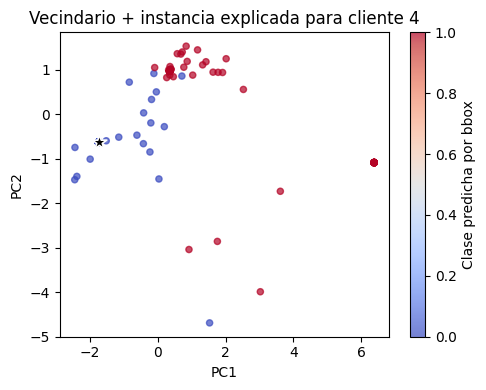

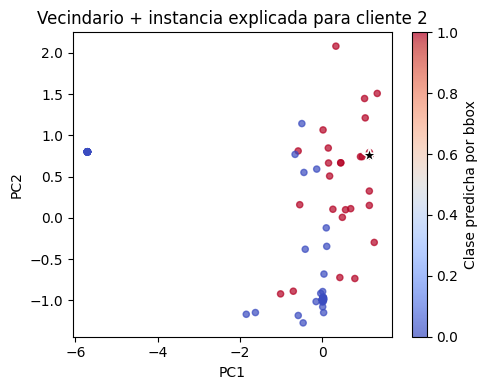

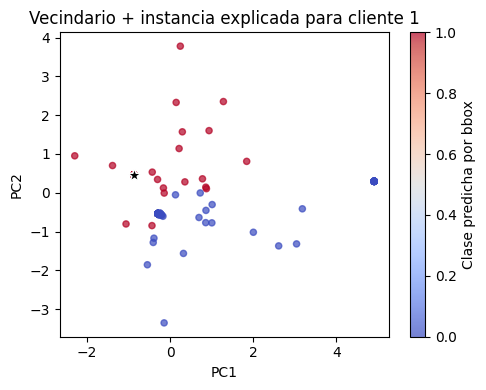

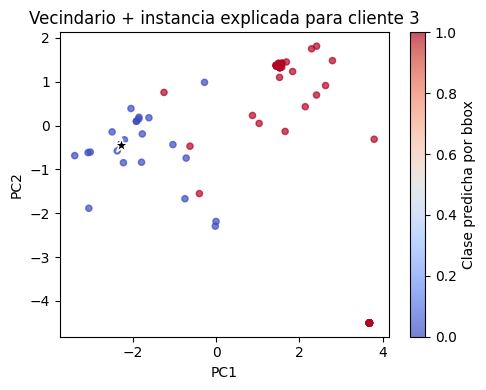

In [7]:
from flwr.simulation import run_simulation
import logging
import warnings
import ray

warnings.filterwarnings("ignore", category=DeprecationWarning)


logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger("filelock").setLevel(logging.WARNING)
logging.getLogger("ray").setLevel(logging.WARNING)
logging.getLogger('graphviz').setLevel(logging.WARNING)
logging.getLogger().setLevel(logging.WARNING)  # O ERROR para ocultar aún más
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("fsspec").setLevel(logging.WARNING)
# logging.getLogger("flwr").setLevel(logging.WARNING)




ray.shutdown()  # Apagar cualquier sesión previa de Ray
ray.init(local_mode=True)  # Desactiva multiprocessing, usa un solo proceso principal

backend_config = {"num_cpus": 1}

run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)
